In [ ]:
# mount the Google Drive
from google.colab import drive
drive.mount("/content/drive")
%cd /content/drive/MyDrive/DSA4212/dataset/assignment_2

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/DSA4212/dataset/assignment_2


In [ ]:
import jax 
from jax.config import config
config.update('jax_enable_x64', True)  # often needed for LBFGS that requires high-precision


import jax.numpy as jnp
import numpy as np
import pylab as plt

import imageio
import os
from skimage.transform import rescale, resize, downscale_local_mean
import pandas as pd
import time
import scipy
from pandas.tseries.frequencies import unique

In [ ]:
test_data=pd.read_csv('assignment_2_ratings_test.csv')
train_data=pd.read_csv('assignment_2_ratings_train.csv')

In [ ]:
#creating a data frame with only anime id and genre, with each genre in the seperate rows 
anime_data=pd.read_csv('assignment_2_anime.csv')
anime_data.genre.fillna("None",inplace=True)
anime_data.genre=anime_data["genre"].apply(lambda x : x.split(','))
anime_data['weights']=1/anime_data.genre.apply(len) #added weights of the genre on anime id
anime_genre=anime_data.explode("genre")[['anime_id','genre','weights']]
anime_genre.genre=anime_genre.genre.apply(lambda x : x.strip())
anime_genre

,anime_id,genre,weights
0,32281,Drama,0.250000
0,32281,Romance,0.250000
0,32281,School,0.250000
0,32281,Supernatural,0.250000
1,5114,Action,0.142857
...,...,...,...
12289,9316,Hentai,1.000000
12290,5543,Hentai,1.000000
12291,5621,Hentai,1.000000
12292,6133,Hentai,1.000000


In [ ]:
def encode_column(column):
    keys = column.unique()
    key_to_id = {key:idx for idx,key in enumerate(keys)}
    return key_to_id, np.array([key_to_id[x] for x in column]), len(keys)

def encode_column_dict(column):
    keys = column.unique()
    key_to_id = {key:idx for idx,key in enumerate(keys)}
    return key_to_id

# This is basically to apply the encode_column function on our columns of choice
def encode_df(data):
    anime_ids, data['anime_id'], num_anime = encode_column(data['anime_id'])
    user_ids, data['user_id'], num_users = encode_column(data['user_id'])
    return data, num_users, num_anime, user_ids, anime_ids

In [ ]:
#creating V matrix 
#values are the weights of each genre on each film 

V_df=anime_genre.groupby([anime_genre.anime_id, 'genre'])['weights'].first().unstack().fillna(0)

#creating a dictonary to convert anime id to the correct row index of matrix V
anime_id_V_dict=encode_column_dict(V_df.index)
V_init=np.array(V_df)


In [ ]:
#addindg genre to training data and test data, 
train_data_genre=pd.merge(train_data,anime_genre,how="left",on="anime_id")
test_data_genre=pd.merge(test_data,anime_genre,how="left",on="anime_id")




In [ ]:
# Using group by to display only the average rating per user per genre of anime for both test and train
train_data_grouped=train_data_genre.groupby(['user_id','genre'],as_index=False)["rating"].mean()
test_data_grouped=test_data_genre.groupby(['user_id','genre'],as_index=False)["rating"].mean()

In [ ]:
#creating U matrix 
# user id are the indexs 
#values are the average rating per genre 
U_train_df=train_data_grouped.groupby([train_data_grouped.user_id, 'genre'])['rating'].first().unstack().fillna(0)


#creating a dictonary to convert user id to the correct row index of matrix U
user_id_U_train_dict=encode_column_dict(U_train_df.index)
#creating matrix U
U_init=np.array(U_train_df)


In [ ]:
#changing the user id  to the encoded ones from train data set
train_data['user_id_encoded']= [user_id_U_train_dict[x] for x in train_data['user_id']]
#changing anime id to those enocded from V matrix 
train_data['anime_id_encoded']= [anime_id_V_dict[x] for x in train_data['anime_id']]


In [ ]:
# changing test data ids to encoded ids

def change_code_test(x,dic):
  try:
    result=dic[x]
  except KeyError:
    dic[x]=len(dic)# those users not in training set is given the last row of matrix 
    result=dic[x] 
  return result

test_data['user_id_encoded']=[change_code_test(x,user_id_U_train_dict) for x in test_data['user_id']]
test_data.loc[test_data['user_id_encoded']==0]

test_data['anime_id_encoded']= [change_code_test(x,anime_id_V_dict)for x in test_data['anime_id']]




In [ ]:
# addind last 0 row to U V matrix

U_init=np.vstack([U_init, np.zeros(44)]) 
#len(U_init)==68422
V_init=np.vstack([V_init, np.zeros(44)])
#len(V_init)=12294

#so for user/film that is in test set but not training set the encoded value will be the last row of U/V
#eg user_id 2
test_data.loc[test_data.user_id==2]

,user_id,anime_id,rating,user_id_encoded,anime_id_encoded
1490816,2,11771,10,68421,6632


In [ ]:
## model using training data 

u_list_train=train_data.user_id_encoded.values
v_list_train=train_data.anime_id_encoded.values
ratings_list_train=train_data.rating.values


In [ ]:
@jax.jit
def model(U, V):
  """
  U: p*r matrix 
  V: q*r matrix
  where p is number of users in training set q is number of anime in the anime data set and r is number of genres
  """
  predictions = jnp.sum(U[u_list_train.astype(int)]*V[v_list_train.astype(int)],axis=1)
  MSE = jnp.mean((predictions -ratings_list_train)**2 )
  return MSE

In [ ]:
#find gradient 
model_grad_U = jax.jit( jax.grad(model, argnums=0) )
model_grad_V = jax.jit( jax.grad(model, argnums=1) )
     

In [ ]:
import tqdm
# doing Gradient descent
niter = 2000
eta = 0.01
loss_traj = []

U = np.copy(U_init)
V = np.copy(V_init)

for _ in tqdm.tqdm(range(niter)):
  # compute my gradients
  grad_u = model_grad_U(U,V)
  grad_v = model_grad_V(U,V)

  # do the GD update
  U = U - eta * grad_u
  V = V - eta * grad_v

  # monitor the loss
  loss_traj.append( model(U,V) )


100%|██████████| 2000/2000 [02:48<00:00, 11.86it/s]


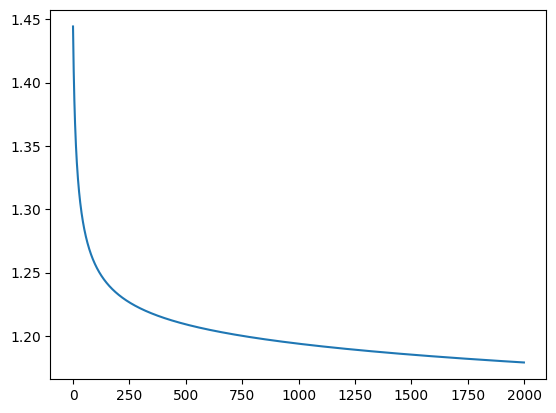

In [ ]:
plt.plot(loss_traj)

In [ ]:
u_list_test = test_data.user_id_encoded.values
v_list_test = test_data.anime_id_encoded.values
ratings_list_test = test_data.rating.values
predictions = jnp.sum(U[u_list_test.astype(int)] * V[v_list_test.astype(int)], axis=1)
MSE = np.mean( (predictions - ratings_list_test)**2 )
MSE

Array(1.93320641, dtype=float64)

Alternating function 

In [ ]:
import tqdm
# doing Gradient descent
niter = 2000
eta = 0.01
loss_traj = []

U = np.copy(U_init)
V = np.copy(V_init)

for _ in tqdm.tqdm(range(niter)):
  # compute my gradients
  grad_u = model_grad_U(U,V)


  # do the GD update
  U = U - eta * grad_u


  # monitor the loss
  loss_traj.append( model(U,V) )
for _ in tqdm.tqdm(range(niter)):
  # compute my gradients

  grad_v = model_grad_V(U,V)

  # do the GD update

  V = V - eta * grad_v

  # monitor the loss
  loss_traj.append( model(U,V) )

100%|██████████| 2000/2000 [01:38<00:00, 20.26it/s]


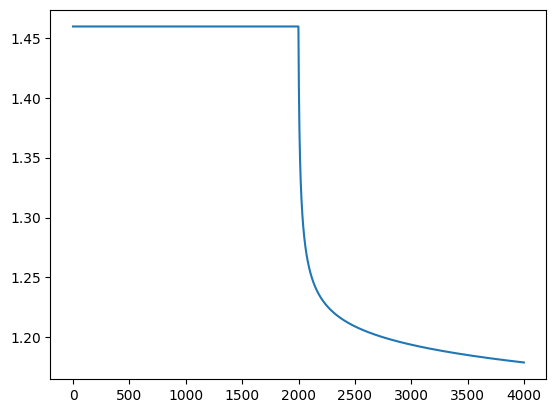

In [ ]:
plt.plot(loss_traj)

In [ ]:
u_list_test = test_data.user_id_encoded.values
v_list_test = test_data.anime_id_encoded.values
ratings_list_test = test_data.rating.values
predictions = jnp.sum(U[u_list_test.astype(int)] * V[v_list_test.astype(int)], axis=1)
MSE = np.mean( (predictions - ratings_list_test)**2 )
MSE

Array(1.93321055, dtype=float64)

In [ ]:
import tqdm
# doing Gradient descent
niter = 2000
eta = 0.01
loss_traj = []

U = np.copy(U_init)
V = np.copy(V_init)

for _ in tqdm.tqdm(range(niter)):
  # compute my gradients

  grad_v = model_grad_V(U,V)

  # do the GD update

  V = V - eta * grad_v

for _ in tqdm.tqdm(range(niter)):
  # compute my gradients
  grad_u = model_grad_U(U,V)


  # do the GD update
  U = U - eta * grad_u


  # monitor the loss
  loss_traj.append( model(U,V) )


  # monitor the loss
  loss_traj.append( model(U,V) )

100%|██████████| 2000/2000 [02:20<00:00, 14.26it/s]


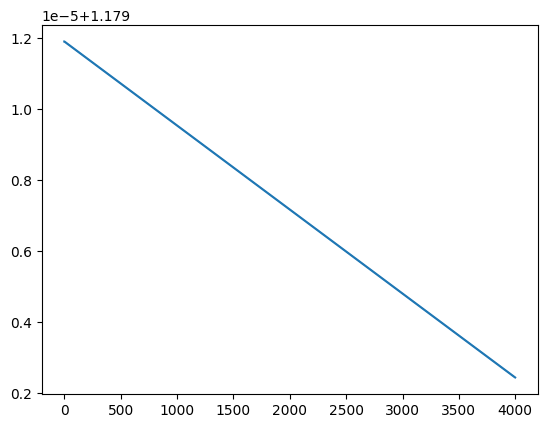

In [ ]:
plt.plot(loss_traj)

In [ ]:
u_list_test = test_data.user_id_encoded.values
v_list_test = test_data.anime_id_encoded.values
ratings_list_test = test_data.rating.values
predictions = jnp.sum(U[u_list_test.astype(int)] * V[v_list_test.astype(int)], axis=1)
MSE = np.mean( (predictions - ratings_list_test)**2 )
MSE

Array(1.93320611, dtype=float64)

Lambda regularization 

In [ ]:

@jax.jit
def reg_model(U, V):
  """
  U: p*r matrix 
  V: q*r matrix
  where p is number of users in training set q is number of anime in the anime data set and r is number of genres
  """
  predictions = jnp.sum(U[u_list_train.astype(int)]*V[v_list_train.astype(int)],axis=1)
  MSE = jnp.mean((predictions -ratings_list_train)**2 )
  lamb=0.1
  #regularization
  reg = lamb * jnp.mean( U**2 ) + lamb * jnp.mean( V**2 )
  reg_MSE= MSE+reg
  return reg_MSE 
     

#find gradient 
reg_model_grad_U = jax.jit( jax.grad(reg_model, argnums=0) )
reg_model_grad_V = jax.jit( jax.grad(reg_model, argnums=1) )

In [ ]:

import tqdm
# doing Gradient descent
niter = 2000
eta = 0.01
loss_traj = []

U = np.copy(U_init)
V = np.copy(V_init)

for _ in tqdm.tqdm(range(niter)):
  # compute my gradients
  grad_u = reg_model_grad_U(U,V)
  grad_v = reg_model_grad_V(U,V)

  # do the GD update
  U = U - eta * grad_u
  V = V - eta * grad_v

  # monitor the loss
  loss_traj.append( reg_model(U,V) )

100%|██████████| 2000/2000 [02:49<00:00, 11.81it/s]


Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float64)

In [ ]:
V[-1]

Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float64)

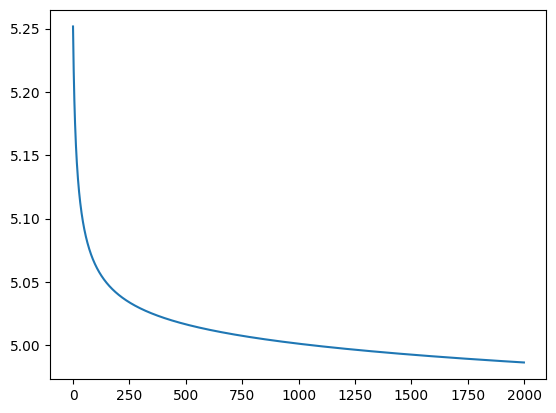

In [ ]:
plt.plot(loss_traj)

In [ ]:

u_list_test = test_data.user_id_encoded.values
v_list_test = test_data.anime_id_encoded.values
ratings_list_test = test_data.rating.values
predictions = jnp.sum(U[u_list_test.astype(int)] * V[v_list_test.astype(int)], axis=1)
MSE = np.mean( (predictions - ratings_list_test)**2 )
MSE

Array(1.93320314, dtype=float64)

Momentum  GD 

In [ ]:
# Gradient descent
niter = 100
eta = 100.
loss_traj = []
B = 0.9
U = np.copy(U_init)
V = np.copy(V_init)

U_tracker = [U_init]
V_tracker = [V_init]

for _ in tqdm.tqdm(range(niter)):
  # compute my gradients
  grad_u = model_grad_U(U,V)
  grad_v = model_grad_V(U,V)
  
  # do the GD update
  U = U - eta * grad_u + B*(U-U_tracker[-1])
  V = V - eta * grad_v + B*(V-V_tracker[-1])

  U_tracker.append(U)
  V_tracker.append(V)
  # monitor the loss
  loss_traj.append( model(U,V) )

u_list_val = valid_data.user_id.values
v_list_val = valid_data.anime_id.values
ratings_list_val = valid_data.rating.values
predictions = jnp.sum(U[u_list_val.astype(int)] * V[v_list_val.astype(int)], axis=1)
MSE = onp.mean( (predictions - ratings_list_val)**2 )
MSE